# Stable Baselines3 Tutorial - Getting Started

Github repo: https://github.com/araffin/rl-tutorial-jnrr19/tree/sb3/

Stable-Baselines3: https://github.com/DLR-RM/stable-baselines3

Documentation: https://stable-baselines3.readthedocs.io/en/master/

RL Baselines3 zoo: https://github.com/DLR-RM/rl-baselines3-zoo

[RL Baselines3 Zoo](https://github.com/DLR-RM/rl-baselines3-zoo) is a collection of pre-trained Reinforcement Learning agents using Stable-Baselines3.

It also provides basic scripts for training, evaluating agents, tuning hyperparameters and recording videos.


## Introduction

In this notebook, you will learn the basics for using stable baselines library: how to create a RL model, train it and evaluate it. Because all algorithms share the same interface, we will see how simple it is to switch from one algorithm to another.


## Install Dependencies and Stable Baselines3 Using Pip

List of full dependencies can be found in the [README](https://github.com/DLR-RM/stable-baselines3).


```
pip install stable-baselines3[extra]
```

In [ ]:
!pip install stable-baselines3[extra]
#!pip install stable-baselines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

Stable-Baselines3 works on environments that follow the [gym interface](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html).
You can find a list of available environment [here](https://gym.openai.com/envs/#classic_control).

It is also recommended to check the [source code](https://github.com/openai/gym) to learn more about the observation and action space of each env, as gym does not have a proper documentation.
Not all algorithms can work with all action spaces, you can find more in this [recap table](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html)

In [ ]:
import gym
import numpy as np

The first thing you need to import is the RL model, check the documentation to know what you can use on which problem

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3 import DDPG
#from stable_baselines import TRPO

The next thing you need to import is the policy class that will be used to create the networks (for the policy/value functions).
This step is optional as you can directly use strings in the constructor: 

```PPO('MlpPolicy', env)``` instead of ```PPO(MlpPolicy, env)```

Note that some algorithms like `SAC` have their own `MlpPolicy`, that's why using string for the policy is the recommened option.

In [ ]:
#from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.ddpg.policies import MlpPolicy

## Create the Gym env and instantiate the agent

For this example, we will use CartPole environment, a classic control problem.

"A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. "

Cartpole environment: [https://gym.openai.com/envs/CartPole-v1/](https://gym.openai.com/envs/CartPole-v1/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)


We chose the MlpPolicy because the observation of the CartPole task is a feature vector, not images.

The type of action to use (discrete/continuous) will be automatically deduced from the environment action space

Here we are using the [Proximal Policy Optimization](https://stable-baselines3.readthedocs.io/en/master/modules/ppo2.html) algorithm, which is an Actor-Critic method: it uses a value function to improve the policy gradient descent (by reducing the variance).

It combines ideas from [A2C](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html) (having multiple workers and using an entropy bonus for exploration) and [TRPO](https://stable-baselines.readthedocs.io/en/master/modules/trpo.html) (it uses a trust region to improve stability and avoid catastrophic drops in performance).

PPO is an on-policy algorithm, which means that the trajectories used to update the networks must be collected using the latest policy.
It is usually less sample efficient than off-policy alorithms like [DQN](https://stable-baselines.readthedocs.io/en/master/modules/dqn.html), [SAC](https://stable-baselines3.readthedocs.io/en/master/modules/sac.html) or [TD3](https://stable-baselines3.readthedocs.io/en/master/modules/td3.html), but is much faster regarding wall-clock time.


In [ ]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt
!pip install odeintw
from odeintw import odeintw

class PassageEnv(Env):
    def __init__(self):
        # Limites y espacio de las acciones [omega1, omega2]
        self.action_space = Box(low=np.array([0,0]), high=np.array([1,1]))
        #  Limites y espacio de los estados: [\rho, sigma1, sigma2]
        self.observation_space = Box(low=np.array([0,0,0,0,0,0,0,0,0,0,0]), 
                                high=np.array([1,1,1,1,1,1,1,1,1,1,1]))
        # Set start state
        self.state = np.array([1,0,0,0,0,0,0,0,0,0,0],dtype=np.complex128)

        self.length_trial = 0


    def refuerzo(self, p3, p2):
        return (-1 + 50*p3 - 20*p2) #+ A(p2)

    def step(self, action):
        # Aplicar accion
        omega1 = action[0]
        omega2 = action[1]

        # Cambiar el hamiltoniano
        def right_part(rho, t):
  
          hamiltonian = np.array([[0     , -omega1,      0  ],
                                  [-omega1,    0.0 , -omega2 ],
                                  [ 0     , -omega2,      0.0]],
                                  dtype=np.complex128)
          return (np.dot(hamiltonian, rho) - np.dot(rho, hamiltonian)) / (1j)

        # Evolucion temporal
        N = 100
        omegamax = 1
        dt = (50*np.pi/omegamax)/N
        #tmax = 10
        tpasos = np.linspace(0,dt,N)
        rho = np.array([[self.state[i] for i in range(0,3)],
                      [self.state[i] for i in range(3,6)],
                      [self.state[i] for i in range(6,9)]], dtype=np.complex128)

        result = odeintw(right_part, rho, tpasos)
        p11, p12, p13 = [],[],[]
        p21, p22, p23 = [],[],[]
        p31, p32, p33 = [],[],[]
        for i in range(0,N):
          resultado = np.reshape(result[i],(9,))
          p11.append(resultado[0])
          p12.append(resultado[1])
          p13.append(resultado[2])

          p21.append(resultado[3])
          p22.append(resultado[4])
          p23.append(resultado[5])

          p31.append(resultado[6])
          p32.append(resultado[7])
          p33.append(resultado[8])

        #final_result = result[-1]
        #final_result = np.reshape(final_result,(9,))

        # Nuevo estado a partir de la matriz densidad obtenida
        #result = final_result
        #result = [np.mean(i) for i in final_result]
        #result = [i[-2] for i in final_result] # Testeando
        #self.state = np.array([result[0], result[1], result[2], result[3], result[4], result[5], result[6], result[7], result[8], omega1, omega2])
        self.state = np.array([np.mean(p11), np.mean(p12), np.mean(p13),
                               np.mean(p21), np.mean(p22), np.mean(p23),
                               np.mean(p31), np.mean(p32), np.mean(p33), omega1, omega2])
        # Calcular el refuerzo
        reward = self.refuerzo(self.state[6], self.state[8])

        done = False
      
        if self.state[4]>0.05:
          reward -= 100

        self.length_trial += 1
      
        if self.state[8] >= 0.99 and self.length_trial==100:
            reward += 1000
            done = True

        if self.length_trial >= 50:
            done = True

        info = {}

        return self.state, reward, done, info

    def render(self):
        pass

    def reset(self):
        self.state = np.array([1,0,0,0,0,0,0,0,0,0,0])
        self.length_trial = 0
        return self.state

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#env = gym.make('CartPole-v1')
env = PassageEnv()

#model = PPO(MlpPolicy, env, verbose=0)
model = DDPG(MlpPolicy, env)

/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


We create a helper function to evaluate the agent:

In [ ]:
def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

Let's evaluate the un-trained agent, this should be a random agent.

In [ ]:
# Random Agent, before training
#mean_reward_before_train = evaluate(model, num_episodes=100)

Stable-Baselines already provides you with that helper:

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
#mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

#print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

## Train the agent and evaluate it

In [ ]:
# Train the agent for 10000 steps
N_steps = 10000
model.learn(total_timesteps=N_steps)

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  self.actions[env_idx]
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  self.buf_obs[key][env_idx] = obs
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/off_policy_algorithm.py:502: ComplexWarning: Casting complex values to real discards the imaginary part
  next_obs[i] = infos[i]["terminal_observation"]


In [ ]:
# Evaluate the trained agent
#mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
#mean_reward_before_train = evaluate(model, num_episodes=100)

#print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

In [ ]:
# Leyendo archivos desde Google drive
GOOGLE_DRIVE = '/content/google_drive'
import numpy as np
from google.colab import drive
drive.mount(GOOGLE_DRIVE)
path = GOOGLE_DRIVE+'/MyDrive/archivos_teorica/'
import os.path
import os

dir_path = path+'BL_3puntos_promedio_'+str(N_steps)+'/'

isExist = os.path.exists(dir_path)

if not isExist:
  os.makedirs(dir_path)

path_file = dir_path+"Baselines_Model_W_"+str(N_steps)+"_episodes"
file_exists = os.path.exists(path_file+'.zip')
print(file_exists)

if not file_exists:
  model.save(path_file)

Drive already mounted at /content/google_drive; to attempt to forcibly remount, call drive.mount("/content/google_drive", force_remount=True).
True


acciones


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  self.actions[env_idx]
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  self.buf_obs[key][env_idx] = obs


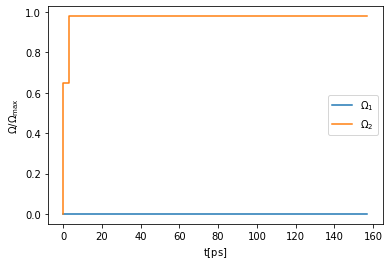

estado


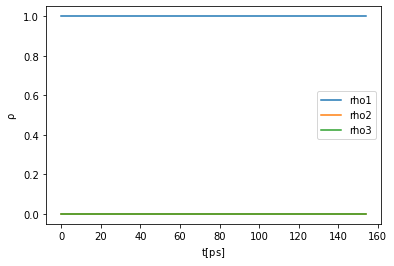

reward


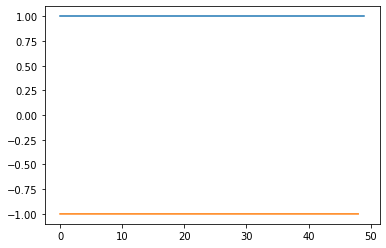

In [ ]:
env = model.get_env()
episode_rewards = []
done = False
obs = env.reset()
actions = []
p1, p2, p3 = [obs[0][0]], [obs[0][4]], [obs[0][8]]
actions.append([[0,0]])
obs, reward, done, info = env.step(actions[0])
while not done:
    # _states are only useful when using LSTM policies
    action, _states = model.predict(obs)
    actions.append(action)
    # here, action, rewards and dones are arrays
    # because we are using vectorized env
    obs, reward, done, info = env.step(action)
    p1.append(obs[0][0])
    p2.append(obs[0][4])
    p3.append(obs[0][8])
    episode_rewards.append(reward)
actions = np.array(actions)
actions.shape

N = len(actions[:,0,0])
tmax = 50*np.pi
tpasos = np.linspace(0,tmax,N)
print('acciones')
plt.xlabel('t[$\mathregular{ps}$]')
plt.ylabel('$\mathregular{\Omega/\Omega_{max}}$')
plt.step(tpasos, actions[:,0,0], label='$\mathregular{\Omega_{1}}$')
plt.step(tpasos, actions[:,0,1], label='$\mathregular{\Omega_{2}}$')
plt.legend()
path_img = dir_path+'Acciones.png'
file_exists = os.path.exists(path_img)
if not file_exists:
  plt.savefig(dir_path+'Acciones.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
print('estado')
plt.plot(tpasos[:-1], p1[:-1], label='rho1')
plt.plot(tpasos[:-1], p2[:-1], label='rho2')
plt.plot(tpasos[:-1], p3[:-1], label='rho3')
plt.legend()
plt.xlabel('t[$\mathregular{ps}$]')
plt.ylabel('$\mathregular{\\rho}$')

path_img = dir_path+'Estado.png'
file_exists = os.path.exists(path_img)
if not file_exists:
  plt.savefig(dir_path+'Estado.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
ptot = np.array(p1)+np.array(p2)+np.array(p3)
plt.plot(ptot)
print('reward')
plt.plot(episode_rewards)
plt.show()

/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


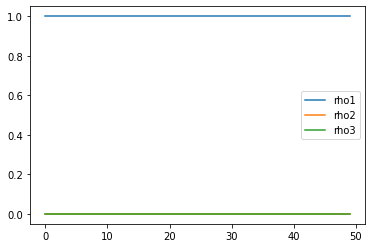

In [ ]:
env = PassageEnv()

p11 = []
p22 = []
p33 = []
for t in range(len(actions[:,0,0])):
  result = env.step([actions[t,0,0], actions[t,0,1]])[0]
  p11.append(result[0])
  p22.append(result[4])
  p33.append(result[8])

plt.plot(p11, label='rho1')
plt.plot(p22, label='rho2')
plt.plot(p33, label='rho3')
plt.legend()
plt.show()

In [ ]:
model.critic

ContinuousCritic(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (qf0): Sequential(
    (0): Linear(in_features=13, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=1, bias=True)
  )
)

In [ ]:
model.actor

Actor(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mu): Sequential(
    (0): Linear(in_features=11, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=2, bias=True)
    (5): Tanh()
  )
)